<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: 한국어 데이터로 챗봇 만들기

# 1 사전 준비

## 1-1. 패키지 load

In [24]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1-2. 기본 code

In [25]:
#  포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    
# 스케일드 닷 프로덕트 어텐션
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# 인코더 층
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 인코더 
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더 층
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 디코더 함수
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 전처리 함수
def preprocess_sentence_kor(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만들기
  # student와 온점 사이에 거리를 만들기
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, 알파벳, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체하기
  sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

# 트랜스포머
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# 2 데이터 준비

## 2-1. 데이터 수집하기

In [3]:
!rm -r /content/data
!mkdir -p /content/data
!wget -O /content/data/ChatbotData.csv https://raw.githubusercontent.com/twelvesense/first-repository/master/ExplNode11/ChatbotData.csv

rm: cannot remove '/content/data': No such file or directory
--2022-06-14 23:38:57--  https://raw.githubusercontent.com/twelvesense/first-repository/master/ExplNode11/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘/content/data/ChatbotData.csv’

/content/data/Chatb 100%[===================>] 868.99K  --.-KB/s    in 0.04s   

2022-06-14 23:38:58 (19.2 MB/s) - ‘/content/data/ChatbotData.csv’ saved [889842/889842]



In [26]:
# data 로드하기
data = pd.read_csv('/content/data/ChatbotData.csv')

In [5]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [27]:
# NaN 확인
data.isnull().sum(axis=0)

Q        0
A        0
label    0
dtype: int64

In [28]:
# 중복 확인
data.duplicated(subset=None, keep='first')

0        False
1        False
2        False
3        False
4        False
         ...  
11818    False
11819    False
11820    False
11821    False
11822    False
Length: 11823, dtype: bool

In [29]:
# 질문과 답변 분리
questions = list(data['Q'])
answers = list(data['A'])

In [30]:
questions

['12시 땡!',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨',
 'SNS보면 나만 빼고 다 행복해보여',
 '가끔 궁금해',
 '가끔 뭐하는지 궁금해',
 '가끔은 혼자인게 좋다',
 '가난한 자의 설움',
 '가만 있어도 땀난다',
 '가상화폐 쫄딱 망함',
 '가스불 켜고 나갔어',
 '가스불 켜놓고 나온거 같아',
 '가스비 너무 많이 나왔다.',
 '가스비 비싼데 감기 걸리겠어',
 '가스비 장난 아님',
 '가장 확실한 건 뭘까?',
 '가족 여행 가기로 했어',
 '가족 여행 고고',
 '가족 여행 어디로 가지?',
 '가족 있어?',
 '가족관계 알려 줘',
 '가족끼리 여행간다.',
 '가족들 보고 싶어',
 '가족들이랑 서먹해',
 '가족들이랑 서먹해졌어',
 '가족들이랑 어디 가지?',
 '가족들이랑 여행 갈거야',
 '가족여행 가야지',
 '가족이 누구야?',
 '가족이랑 여행 가려고',
 '가족한테 스트레스 풀었어',
 '가출할까?',
 '가출해도 갈 데가 없어',
 '간만에 떨리니까 좋더라',
 '간만에 쇼핑 중',
 '간만에 휴식 중',
 '간식 뭐 먹을까',
 '간식 추천',
 '간장치킨 시켜야지',
 '간접흡연 싫어',
 '갈까 말까 고민 돼',
 '갈까 말까?',
 '감 말랭이 먹고 싶다.',
 '감 말랭이 먹어야지',
 '감기 같애',
 '감기 걸린 것 같아',
 '감기 기운이 있어',
 '감기 들 거 같애',
 '감기가 오려나',
 '감기약이 없어',
 '감기인거 같애',
 '감미로운 목소리 좋아',
 '감정이 쓰레기통처럼 엉망진창이야',
 '감정컨트롤을 못하겠어',
 '감정컨트롤이 안돼',
 '감히 나를 무시하는 애가 있어',
 '갑자기 나쁜 생각이 막 들더라',
 '갑자기 눈물 나',

In [31]:
answers

['하루가 또 가네요.',
 '위로해 드립니다.',
 '여행은 언제나 좋죠.',
 '여행은 언제나 좋죠.',
 '눈살이 찌푸려지죠.',
 '다시 새로 사는 게 마음 편해요.',
 '다시 새로 사는 게 마음 편해요.',
 '잘 모르고 있을 수도 있어요.',
 '시간을 정하고 해보세요.',
 '시간을 정하고 해보세요.',
 '자랑하는 자리니까요.',
 '그 사람도 그럴 거예요.',
 '그 사람도 그럴 거예요.',
 '혼자를 즐기세요.',
 '돈은 다시 들어올 거예요.',
 '땀을 식혀주세요.',
 '어서 잊고 새출발 하세요.',
 '빨리 집에 돌아가서 끄고 나오세요.',
 '빨리 집에 돌아가서 끄고 나오세요.',
 '다음 달에는 더 절약해봐요.',
 '따뜻하게 사세요!',
 '다음 달에는 더 절약해봐요.',
 '가장 확실한 시간은 오늘이에요. 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '더 가까워질 기회가 되겠네요.',
 '저도요.',
 '다들 바빠서 이야기할 시간이 부족했나봐요.',
 '다들 바빠서 이야기할 시간이 부족했나봐요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '좋은 생각이에요.',
 '더 가까워질 기회가 되겠네요.',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '좋은 생각이에요.',
 '정말 후회할 습관이에요.',
 '무모한 결정을 내리지 마세요.',
 '선생님이나 기관에 연락해보세요.',
 '떨리는 감정은 그 자체로 소중해요.',
 '득템했길 바라요.',
 '휴식도 필요하죠.',
 '단짠으로 두 개 사는게 진리죠.',
 '단짠으로 두

In [32]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(data)
MAX_SAMPLES

11823

In [33]:
sent_len = [len(t) for t in questions] + [len(t) for t in answers]
sent_len[:20]

[6, 11, 12, 15, 7, 9, 7, 14, 23, 17, 19, 6, 11, 11, 9, 10, 10, 10, 14, 14]

Text(0, 0.5, 'Number of Sentences')

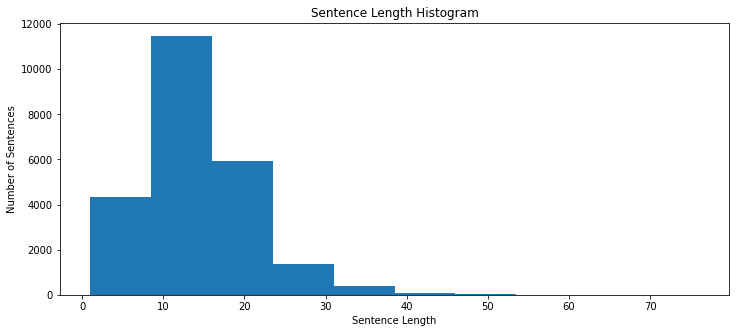

In [34]:
# 문장길이 확인
plt.figure(figsize=(12, 5))
plt.hist(sent_len)
plt.title('Sentence Length Histogram')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

In [35]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

## 2-2. 데이터 전처리하기

In [36]:
# tokenizer로 SubwordTextEncoder 사용하기
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [37]:
# subwords
tokenizer.subwords[:20]

['거예요',
 '수_',
 '게_',
 '너무_',
 '더_',
 '거_',
 '좋아하는_',
 '는_',
 '이_',
 '을_',
 '잘_',
 '도_',
 '. ',
 '고_',
 '요',
 '것_',
 '많이_',
 '안_',
 '좋은_',
 '같아요']

In [38]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여하기
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [39]:
# 토큰화 및 필터링
questions, answers = tokenize_and_filter(questions, answers)
questions


array([[8170, 7909, 4200, ...,    0,    0,    0],
       [8170, 7963,   44, ...,    0,    0,    0],
       [8170, 7965, 1431, ...,    0,    0,    0],
       ...,
       [8170, 8151, 8071, ...,    0,    0,    0],
       [8170,  131,  163, ...,    0,    0,    0],
       [8170, 1948,  881, ...,    0,    0,    0]], dtype=int32)

In [40]:
answers

array([[8170, 3837,   71, ...,    0,    0,    0],
       [8170, 1826, 5495, ...,    0,    0,    0],
       [8170, 3393,  774, ...,    0,    0,    0],
       ...,
       [8170, 5204,  284, ...,    0,    0,    0],
       [8170,   11, 3194, ...,    0,    0,    0],
       [8170,  218,  551, ...,    0,    0,    0]], dtype=int32)

## 2-3. 교사 강요 사용하기

In [41]:
# 교사 강요 사용하기
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 3 모델 준비

## 3-1 모델 생성

In [42]:
# 모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3146240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

## 3-2. 손실함수

In [44]:
# 손실함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## 3-3. 커스텀된 학습률

Text(0.5, 0, 'Train Step')

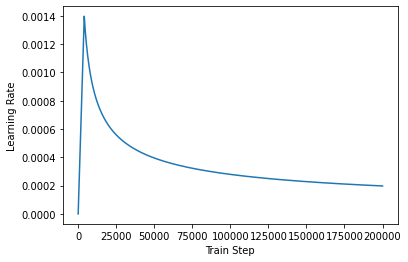

In [45]:
# 커스텀된 학습률
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 3-4. 모델 컴파일

In [46]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## 3-5. 모델 훈련

In [51]:
# 모델 훈련
EPOCHS = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[early_stopping])

Epoch 1/20
185/185 [==============================] - 52s 283ms/step - loss: 0.7218 - accuracy: 0.0705
Epoch 2/20
185/185 [==============================] - 53s 285ms/step - loss: 0.6449 - accuracy: 0.0786
Epoch 3/20
185/185 [==============================] - 52s 284ms/step - loss: 0.5637 - accuracy: 0.0876
Epoch 4/20
185/185 [==============================] - 52s 282ms/step - loss: 0.4810 - accuracy: 0.0973
Epoch 5/20
185/185 [==============================] - 53s 286ms/step - loss: 0.3982 - accuracy: 0.1077
Epoch 6/20
185/185 [==============================] - 52s 283ms/step - loss: 0.3190 - accuracy: 0.1190
Epoch 7/20
185/185 [==============================] - 52s 283ms/step - loss: 0.2481 - accuracy: 0.1294
Epoch 8/20
185/185 [==============================] - 52s 282ms/step - loss: 0.1855 - accuracy: 0.1394
Epoch 9/20
185/185 [==============================] - 52s 279ms/step - loss: 0.1371 - accuracy: 0.1479
Epoch 10/20
185/185 [==============================] - 52s 281ms/step - l

# 4 모델 평가

## 4-1. 예측 code 구성

In [52]:
def decoder_inference(sentence):
  sentence = preprocess_sentence_kor(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

def sentence_generation(sentence):
      # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

## 4-2. 예측 성능 평가

##### █ 임의의 문장으로부터 챗봇의 대답을 얻기


In [53]:
sentence_generation('안녕하세요?')

입력 : 안녕하세요?
출력 : 안녕하세요.


'안녕하세요.'

In [54]:
sentence_generation('심심해요.')

입력 : 심심해요.
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [55]:
sentence_generation('음악 추천해줘요.')

입력 : 음악 추천해줘요.
출력 : 더 갈렸나봐요.


'더 갈렸나봐요.'

In [56]:
sentence_generation('오늘 같이 영화볼까요?')

입력 : 오늘 같이 영화볼까요?
출력 : 영화관 말고 다른 데서 보세요.


'영화관 말고 다른 데서 보세요.'

In [57]:
sentence_generation('제발 이러지 말아주세요.')

입력 : 제발 이러지 말아주세요.
출력 : 이젠 기억을 놓아주세요.


'이젠 기억을 놓아주세요.'

# 5 회고

* 주관적 판단으로, 5번의 나름 상이한 난이도의 질문들에 대해서, 기대이상의 성능을 보였다고 생각한다.
* 1,2번째 질문에 대해서는 정확한 일상대화로 볼 수 있었다.
* 4,5번째 질문에 대해서는 농담이나 조금 비꼬는 듯한 느낌으로 볼 수도 있어 괜찮았다.
* 다만, 3번째 질문에 대한 응답만 좀 어색해서 조금 만족스럽지 못했다.
> 3번째 질문: "음악 추천해줘요."<br>
> 3번째 응답: "더 갈렸나봐요."
* 아래의 본 시험에서의 하이퍼파라미터를 조절하면, 성능개선을 기대할 수 있을 것이다.
> EPOCHS = 20 # epoch 횟수<br>
> NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수<br>
> D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원<br>
> NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 <br>
> UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기<br>
> DROPOUT = 0.1 # 드롭아웃의 비율